In [31]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from itertools import chain
from sklearn.metrics import classification_report


In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1146801780302991861
]
Num GPUs Available:  0


In [33]:
df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "unicode-escape", error_bad_lines=False)
df = df[:600000]
df = df.fillna(method='ffill')
df.head()

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


<AxesSubplot:>

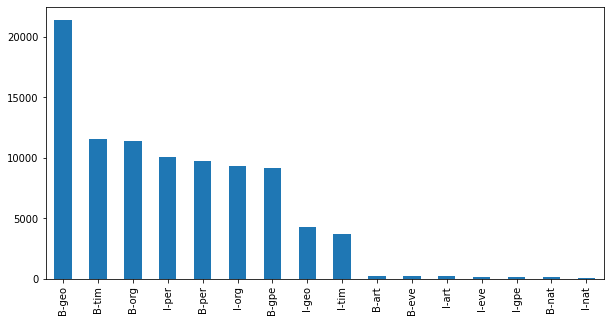

In [34]:
df[df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

In [35]:
#Create mapper for features

tag_vocab = np.unique(df['Tag']).tolist()
word_vocab = np.unique(df['Word']).tolist()

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

In [36]:
#Append index columns for words and tags and group dataframe by sentence

df['Word_index'] = df['Word'].map(word_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_16816/2204932765.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


In [37]:
max_tag = len(tag_vocab)
max_word = len(word_vocab)

tokens = df_grouped['Word_index'].tolist()
tags = df_grouped['Tag_index'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post', value= max_word - 1)


pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding='post', value= tag_to_i["O"])
n_tags = len(tag_to_i)
pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.2, random_state=42)

In [38]:
input_dim = len(word_vocab)+1
output_dim = 64
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])

In [39]:
root_logdir = os.path.join(os.curdir, "../logged_models/mlp")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [40]:
model = tf.keras.models.Sequential(
    [
        layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length), # Embedding vs Input layer
        layers.TimeDistributed(layers.Dense(n_tags, activation="softmax")) #Use softmax for activation HOML page 383
    ]
)

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 64)           1729792   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 17)           1105      
Total params: 1,730,897
Trainable params: 1,730,897
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
#Run in command line
#tensorboard --logdir=C:\Users\Rasmu\Documents\Repos\BAC\Ezra\linguistic\logged_models --port=8888

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_tokens, np.array(train_tags), epochs=25, callbacks=[tensorboard_cb, earlystopping, lr_scheduler], validation_split=0.2)
model.save("../saved_models/mlp.h5")

Epoch 1/25
549/549 [==============================] - 8s 13ms/step - loss: 0.1180 - accuracy: 0.9844 - val_loss: 0.0486 - val_accuracy: 0.9878
Epoch 2/25
549/549 [==============================] - 7s 13ms/step - loss: 0.0326 - accuracy: 0.9903 - val_loss: 0.0475 - val_accuracy: 0.9877
Epoch 3/25
549/549 [==============================] - 7s 12ms/step - loss: 0.0292 - accuracy: 0.9905 - val_loss: 0.0470 - val_accuracy: 0.9880
Epoch 4/25
549/549 [==============================] - 7s 12ms/step - loss: 0.0281 - accuracy: 0.9907 - val_loss: 0.0467 - val_accuracy: 0.9881
Epoch 5/25
549/549 [==============================] - 7s 13ms/step - loss: 0.0272 - accuracy: 0.9908 - val_loss: 0.0466 - val_accuracy: 0.9882
Epoch 6/25
549/549 [==============================] - 7s 12ms/step - loss: 0.0267 - accuracy: 0.9909 - val_loss: 0.0468 - val_accuracy: 0.9883
Epoch 7/25
549/549 [==============================] - 7s 12ms/step - loss: 0.0262 - accuracy: 0.9910 - val_loss: 0.0471 - val_accuracy: 0.9883

In [42]:
y_pred = model.predict(test_tokens) #Calculates probability for each tag

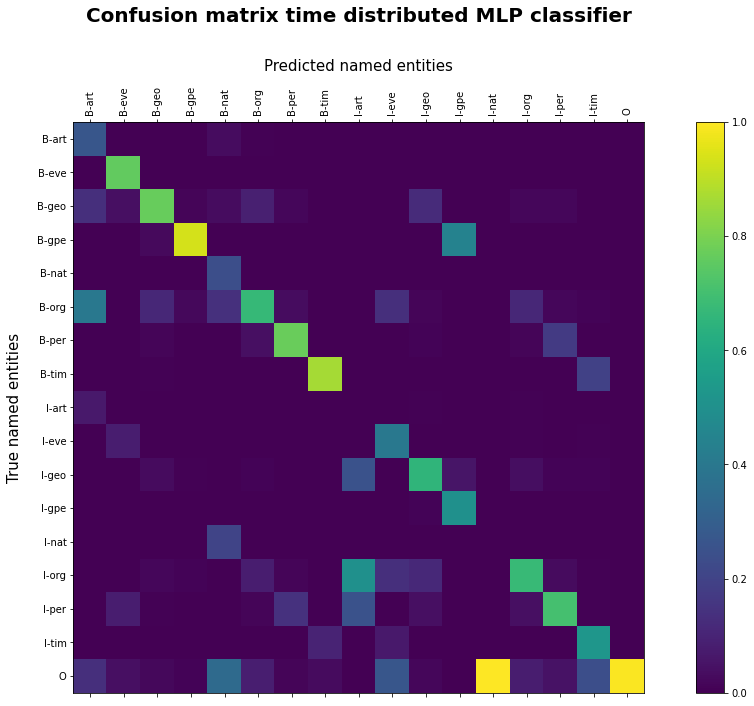

In [43]:
y_classes = y_pred.argmax(axis=-1)

cm_true = np.array(test_tags).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

cm = confusion_matrix(cm_true, cm_pred, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix time distributed MLP classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(tag_vocab)), tag_vocab, rotation=90)
plt.yticks(range(len(tag_vocab)), tag_vocab)
plt.show()

In [44]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:17]
df_perf_2.insert(loc=0, column='Tag', value=tag_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Rasmu\AppData\Local\Temp/ipykernel_16816/3817667430.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Tag,precision,recall,f1-score,support
0,B-art,0.27,0.10,0.14,42.0
1,B-eve,0.76,0.35,0.48,54.0
2,B-geo,0.77,0.82,0.80,4271.0
3,B-gpe,0.93,0.92,0.93,1796.0
4,B-nat,0.24,0.26,0.25,27.0
5,B-org,0.67,0.50,0.57,2342.0
6,B-per,0.77,0.63,0.70,2018.0
7,B-tim,0.86,0.79,0.83,2194.0
8,I-art,0.00,0.00,0.00,43.0
9,I-eve,0.40,0.15,0.21,41.0


In [45]:
unique_classes = []

for i in cm_pred:
    unique_classes.append(i_to_tag[i])

set(unique_classes)

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}